## Scope
This notebook shows how to use the fast waveform generators:

* LDC
* GPU accelerated waveforms

The objective is to:

* Generate fast waveforms in the frequency domain for Galactic binaries (GB)
* Generate fast waveforms in the frequency domain for Massive black hole binaries (MBHB)
* Generate fast waveforms for EMRIs

### Import necessary packages

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

from bbhx.waveformbuild import BBHWaveformFD

from bbhx.utils.constants import *

import ldc.waveform.fastGB as fastGB 
from ldc.lisa.orbits import Orbits

from lisabeta.lisa.lisa import GenerateLISATDISignal_SMBH, EvaluateTDIFreqseries
import lisabeta.lisa.pyresponse as pyresponse

from few.waveform import GenerateEMRIWaveform

/Users/michaelkatz/anaconda3/envs/tutor_env/lib/python3.7/site-packages/gbgpu-0.1-py3.7-macosx-10.9-x86_64.egg/gbgpu/gbgpu.py:24: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/Users/michaelkatz/anaconda3/envs/tutor_env/lib/python3.7/site-packages/gbgpu-0.1-py3.7-macosx-10.9-x86_64.egg/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


### Galactic Binary Waveforms

There are two Galactic binary waveform options shown here. 

* `FastGB` from the LDC: `import ldc.waveform.fastGB.FastGB`. This waveform is built in cython and takes a single binary as input. (Littenberg, Cornish, Babak, Robson, Le Jeune)
* `GBGPU` from Katz+: `gbgpu.gbgpu.GBGPU`. Documentation can be found here: [mikekatz04.github.io/GBGPU](https://mikekatz04.github.io/GBGPU/html/index.html). `GBGPU` is vectorized and can be run on GPUs.

#### Setup all parameters and waveform generators

In [2]:
dt = 10.0
Tobs = 4.0 * YEAR


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude


# for batching with GBGPU
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)

params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

fastgb_gen = fastGB.FastGB(delta_t=dt, T=Tobs)
gbgpu_gen = GBGPU(use_gpu=False)


#### Run the waveforms and plot

Mismatch: 7.771561172376096e-16


/Users/michaelkatz/anaconda3/envs/tutor_env/lib/python3.7/site-packages/gbgpu-0.1-py3.7-macosx-10.9-x86_64.egg/gbgpu/utils/utility.py:265: UserWarning: Sensitivity information not available. The number of points in the waveform will not be determined byt the signal strength without the availability of the Sensitivity.
  "Sensitivity information not available. The number of points in the waveform will not be determined byt the signal strength without the availability of the Sensitivity."
/Users/michaelkatz/anaconda3/envs/tutor_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


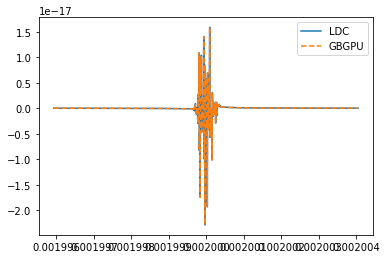

In [3]:

Xs, Ys, Zs = fastgb_gen.get_fd_tdixyz(f0=params[1, 0], fdot=params[2, 0], ampl=params[0, 0],
                      theta=np.pi / 2 - params[8, 0], phi=params[7, 0], psi=params[6, 0], incl=params[5, 0], phi0=params[4, 0], oversample=4)

gbgpu_gen.run_wave(*params, dt=dt, T=Tobs, oversample=4)
A_gbgpu = gbgpu_gen.A[0]
E_gbgpu = gbgpu_gen.E[0]
f_gbgpu = gbgpu_gen.freqs[0]

As, Es, Ts = AET(Xs, Ys, Zs)

mismatch = 1- np.dot(As.conj(), A_gbgpu) / np.sqrt(np.dot(As.conj(), As) * np.dot(A_gbgpu.conj(), A_gbgpu))
print("Mismatch:", mismatch.real)

plt.plot(As.f, As, label="LDC")
plt.plot(f_gbgpu, A_gbgpu.real, '--', label="GBGPU")
plt.legend()

### Massive Black Hole waveforms

There are two Massive Black Hole waveform options shown here. 

* `lisabeta` from the Sylvain Marsat: `from lisabeta.lisa.lisa import GenerateLISATDISignal_SMBH, EvaluateTDIFreqseries`. This waveform takes a single binary as input. Sylvain will talk more about `lisabeta` later on. 
* `BBHx` from Michael Katz: `bbhx.waveform.BBHWaveformFD`. Documentation can be found here: [mikekatz04.github.io/BBHx](https://mikekatz04.github.io/BBHx/html/index.html). `BBHx` is vectorized and can be run on GPUs.

#### Setup parameters

In [4]:
fRef = 0.0
phi0 = 0.0
m1 = 4615384.615384615
m2 = 1384615.3846153845
a1 = 0.5
a2 = 0.2
dist = 6791.810623950793
inc = 1.0471975511965976
beta = 1.0471975511965976
lam = 0.7853981633974483
psi = 0.7853981633974483
tRef = 1.0 * YRSID_SI

freq = np.logspace(-4, 0, 1024)
freq_new = np.logspace(-4, 1, 100000)
modes = [(2,2)]


#### Setup `lisabeta`

In [5]:

lb_params = dict(m1=m1,               # Redshifted mass of body 1 (solar masses)
        m2=m2,               # Redshifted mass of body 2 (solar masses)
        chi1=a1,             # Dimensionless spin of body 1 (in [-1, 1])
        chi2=a2,             # Dimensionless spin of body 2 (in [-1, 1])
        Deltat=tRef,           # Time shift (s)
        dist=dist,             # Luminosity distance (Mpc)
        inc=inc,              # Inclination angle (rad)
        phi=phi0,              # Observer's azimuthal phase (rad)
        beta=beta,             # Source latitude (rad)
        psi=psi)
lb_params['lambda'] = lam

Tobs_yr = 1.2 * YRSID_SI

#Orbits initialization
lisa_params = pyresponse.LISAconstDict["Proposal"]


wvf_pars = {
            "minf": 1e-5,  "maxf": 0.1,
            "timetomerger_max": 1.0,
            "fend": None, "tmin": None, "tmax": Tobs_yr,
            "TDI": "TDIAET", "acc": 1e-4,
            "order_fresnel_stencil": 0,
            "LISAconst": lisa_params,
            "responseapprox": "full",
            "frozenLISA": False,
            "TDIrescaled": False,
        }


#### Setup `BBHx`

In [6]:

katz_params = [m1,               # Redshifted mass of body 1 (solar masses)
        m2,               # Redshifted mass of body 2 (solar masses)
        a1,             # Dimensionless spin of body 1 (in [-1, 1])
        a2,             # Dimensionless spin of body 2 (in [-1, 1])
        dist * 1e6 * PC_SI,             # Luminosity distance (Mpc)
        phi0,              # Observer's azimuthal phase (rad)
        fRef,
        inc,              # Inclination angle (rad)
        lam,           # Source longitude (rad)
        beta,             # Source latitude (rad)
        psi,
        tRef,]  # Time shift (s)         


katz_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=True), use_gpu=False)


#### Create Waveforms

In [7]:
lb_temp = GenerateLISATDISignal_SMBH(lb_params, modes=[(2, 2)], approximant='IMRPhenomD', tf_method='analytical', **wvf_pars)


lb_wave_all = np.conj(EvaluateTDIFreqseries(lb_temp['tdi'], freq_new)[(2, 2)]['chan1'])

katz_wave_all = katz_gen(*katz_params, freqs=freq_new, modes=[(2,2)], direct=False, length=1024, fill=True, t_obs_end=0.0)[0, 0] 

mismatch = 1- np.dot(lb_wave_all.conj(), katz_wave_all) / np.sqrt(np.dot(lb_wave_all.conj(), lb_wave_all) * np.dot(katz_wave_all.conj(), katz_wave_all))
print("Mismatch:", mismatch.real)

Mismatch: 5.292802862655321e-10


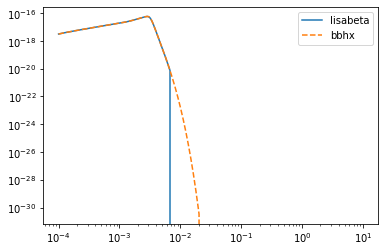

In [8]:
plt.loglog(freq_new, np.abs(lb_wave_all), label="lisabeta")
plt.loglog(freq_new, np.abs(katz_wave_all), '--', label="bbhx")
plt.legend()

### EMRI Waveforms

EMRI waveforms coming to the LDC with be from the `FastEMRIWaveforms` package. Documentation can be found here: [bhptoolkit.org/FastEMRIWaveforms](https://bhptoolkit.org/FastEMRIWaveforms/html/index.html). `FastEMRIWaveforms` is also GPU-accelerated. 

With `FastEMRIWaveforms`, there are two main waveform choices:
* Adiabatic Schwarzschild Eccentric Relativistic
* 5PN trajectory + AAK Waveform

#### Setup parameters and waveform generators

In [9]:
gen_wave_rel = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux", use_gpu=False)
gen_wave_aak = GenerateEMRIWaveform("Pn5AAKWaveform", use_gpu=False)

# parameters
T = 0.01  # observation time (years)
dt = 15.0  # time step (seconds)
M = 1e6 # large mass (solar)
a = 0.1  # spin / will be ignored in Schwarzschild waveform
mu = 1e1  # small mass (solar)
p0 = 12.0  # initial separation
e0 = 0.2  # initial eccentricity
x0 = 0.8  # initial cosine of the inclination / will be ignored in Schwarzschild waveform
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0  # initial phase in phi
Phi_theta0 = 2.0  #  initial phase in theta
Phi_r0 = 3.0  #  initial phase in r



#### Generate waveforms and plot

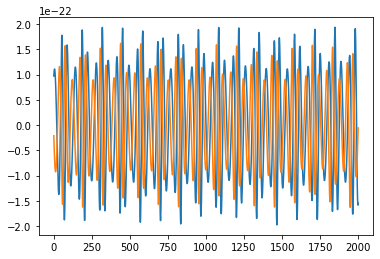

In [10]:
h_rel = gen_wave_rel(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

h_aak = gen_wave_aak(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h_rel.real[:2000])
plt.plot(h_aak.real[:2000])